A Data-Driven Approach to Asymmetric Hydrogenation of Alkenes

Group 7: Zoe Zhang, Qi Wu, Yilun Li

Abstract:

The asymmetric hydrogenation reaction is one of the most crucial chiral construction methods in molecular synthesis, widely applied in the synthesis of pharmaceuticals and natural products. However, the lack of efficient predictive design strategies, combined with the variability of conditions required for different substrates, makes the development of asymmetric hydrogenation catalysts a time-consuming and costly process. To address this challenge, we built a database of approximately 2,000 asymmetric hydrogenation reactions from existing literature, extracting both quantum chemical and geometric descriptors of substrates and catalysts (all structures optimized via the XTB), along with their enantioselectivity. After applying principal component analysis and dimensionality reduction, we plan to employ a Bayesian Neural Network to build a regression model that uses these descriptors as features to predict enantioselectivity. Unlike conventional machine learning approaches based solely on traditional supervised learning, which only provides predictions, our Bayesian Neural Network model aims to predict the ee% values accurately while also providing confidence intervals for these predictions, enabling a more informed approach to catalyst screening and experimental design.


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold, cross_val_score


import torch
import torch.nn as nn
import torchbnn as bnn


In [2]:
class VIFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=5.0):
        self.threshold = threshold
        self.features_to_keep = None
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        # Store feature names from the training data
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns
        else:
            self.feature_names_in_ = [f'feature_{i}' for i in range(X.shape[1])]
        
        # Convert X to DataFrame if it is a NumPy array
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        
        # Calculate VIF for each feature
        vif_data = pd.DataFrame()
        vif_data["feature"] = X.columns
        vif_data["VIF"] = [sm.OLS(X[col], sm.add_constant(X.drop(columns=[col]))).fit().rsquared for col in X.columns]
        vif_data["VIF"] = [1 / (1 - rsq) if rsq < 1 else np.inf for rsq in vif_data["VIF"]]
        
        # Keep features with VIF below the threshold
        self.features_to_keep = vif_data[vif_data["VIF"] < self.threshold]["feature"].tolist()
        return self

    def transform(self, X):
        # Convert X to DataFrame if it is a NumPy array
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        
        # Return DataFrame with only the selected features
        return X[self.features_to_keep]

    def attrib(self, X):
        # Convert X to DataFrame if it is a NumPy array
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        
        # Return selected features and their VIF values
        return {"features_to_keep": self.features_to_keep, "VIF Values": X[self.features_to_keep]}


Linear Model

Train R²: 0.2662, MAE: 0.6792
Test R²: 0.1963, MAE: 0.6824


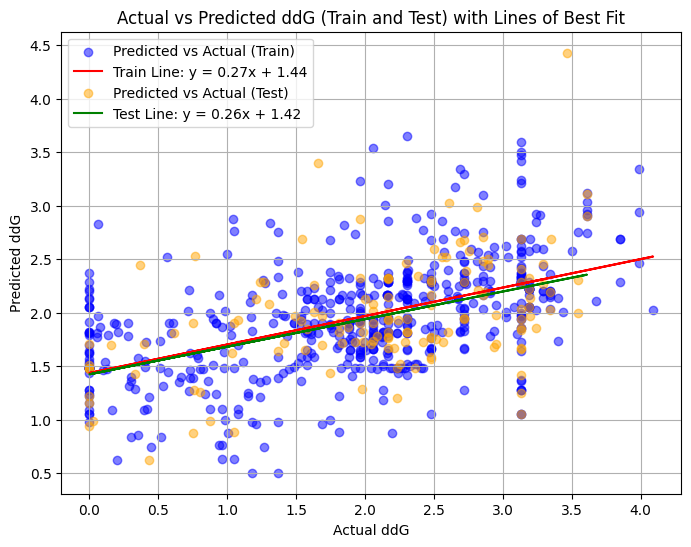

In [59]:
df = pd.read_excel('reordered_final_merged_cleaned_qqm_molecule_charges.xlsx')

# Filter for Tri_Q2 subset
tri_q2_df = df[df['_Alkene_Type'] == 'Tri_Q4']

# Prepare features and target
X = tri_q2_df.drop(columns=['Rxn ID', 'Reactant ID', 'Catalyst ID', 'ddG', '_Alkene_Type', 'ee'])
X = X.loc[:, ~X.columns.str.contains('Q4')] # Drop features in Q2
y = tri_q2_df['ddG']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store feature names in VIFSelector before scaling
vif_selector = VIFSelector()
vif_selector.feature_names_in_ = X_train.columns

# Create the pipeline (VIF Selector and scaling will only be applied to training data)
pipe = Pipeline([
    ('scaler', MinMaxScaler()),  # MinMaxScaler will be fit on training data and applied to both train and test sets
    ('vif', vif_selector),       # VIFSelector will be fit on training data and applied to both train and test sets
    ('lr', LinearRegression())   # Linear regression model
])

# Fit the pipeline on the training data (scaling and VIF selection are done on training data ONLY!!!)
pipe.fit(X_train, y_train)

# Predictions and metrics for the training data
pred_X_train = pipe.predict(X_train)
r2_train = r2_score(y_train, pred_X_train)
mae_train = mean_absolute_error(y_train, pred_X_train)

# Predictions and metrics for the test data
pred_X_test = pipe.predict(X_test)
r2_test = r2_score(y_test, pred_X_test)
mae_test = mean_absolute_error(y_test, pred_X_test)

# Print R^2 and MAE for both train and test sets
print(f"Train R²: {r2_train:.4f}, MAE: {mae_train:.4f}")
print(f"Test R²: {r2_test:.4f}, MAE: {mae_test:.4f}")

# Line of best fit for train and test metrics
slope_train, intercept_train = np.polyfit(y_train, pred_X_train, 1)
slope_test, intercept_test = np.polyfit(y_test, pred_X_test, 1)

# Plotting both train and test predictions in the same space
plt.figure(figsize=(8, 6))
plt.scatter(y_train, pred_X_train, color='blue', alpha=0.5, label='Predicted vs Actual (Train)')
plt.plot(y_train, slope_train * y_train + intercept_train, color='red', label=f'Train Line: y = {slope_train:.2f}x + {intercept_train:.2f}')
plt.scatter(y_test, pred_X_test, color='orange', alpha=0.5, label='Predicted vs Actual (Test)')
plt.plot(y_test, slope_test * y_test + intercept_test, color='green', label=f'Test Line: y = {slope_test:.2f}x + {intercept_test:.2f}')
plt.xlabel('Actual ddG')
plt.ylabel('Predicted ddG')
plt.title('Actual vs Predicted ddG (Train and Test) with Lines of Best Fit')
plt.legend()
plt.grid(True)
plt.show()

RamdomizedSearchCV on all of the models to pick the best parameters

/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Model: OLS
Best Parameters: {'model__n_jobs': None, 'model__fit_intercept': False}
Train R²: 0.2729, MAE: 0.6810
Test R²: 0.2138, MAE: 0.6817


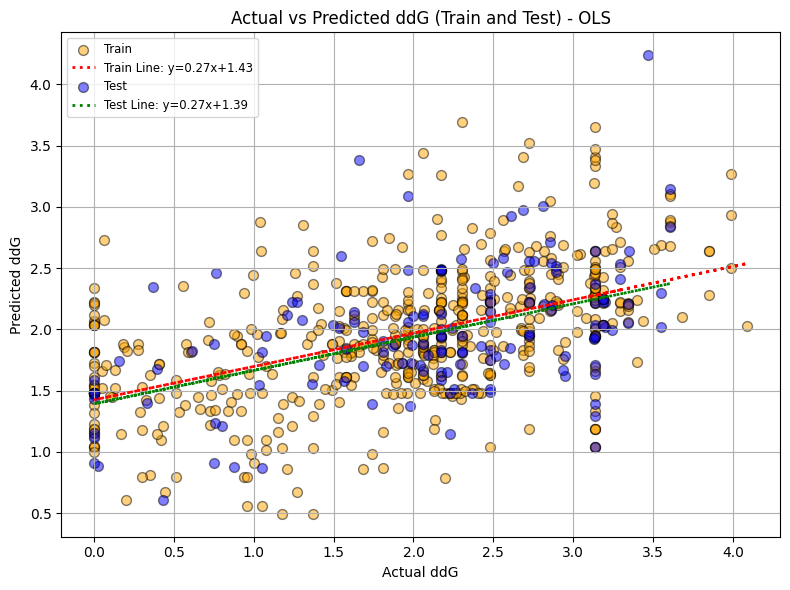


Model: PLS
Best Parameters: {'model__n_components': 4}
Train R²: 0.2670, MAE: 0.6817
Test R²: 0.2145, MAE: 0.6822


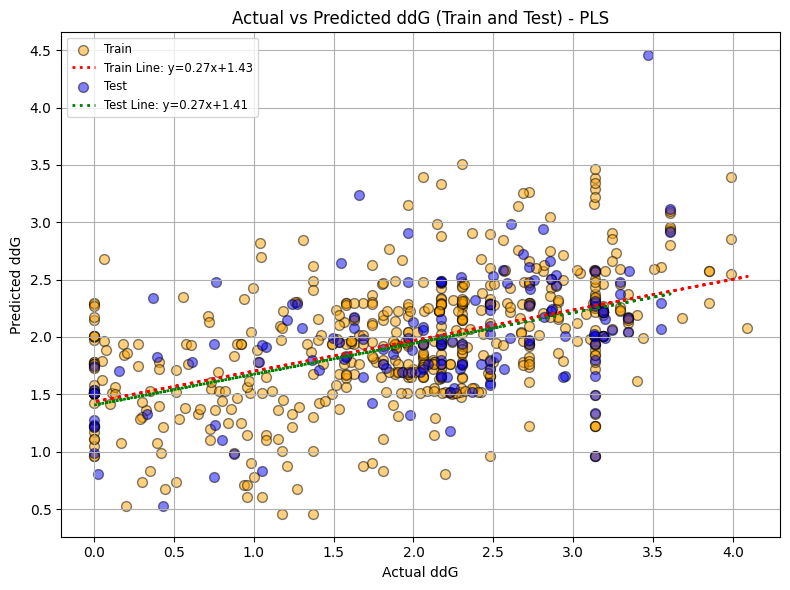


Model: Lasso
Best Parameters: {'model__alpha': 0.03058449429580245}
Train R²: 0.1132, MAE: 0.7703
Test R²: 0.0868, MAE: 0.7633


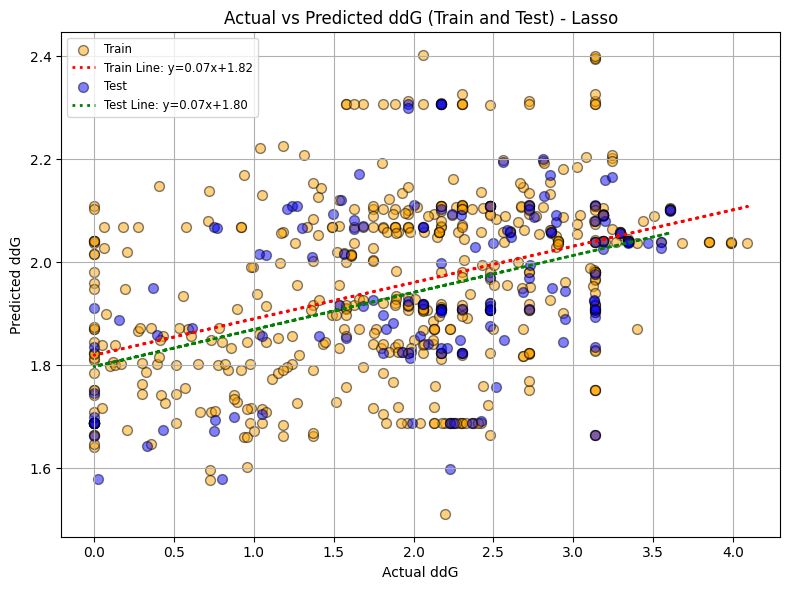


Model: Ridge
Best Parameters: {'model__alpha': 1.5699452033620265}
Train R²: 0.2693, MAE: 0.6835
Test R²: 0.2269, MAE: 0.6794


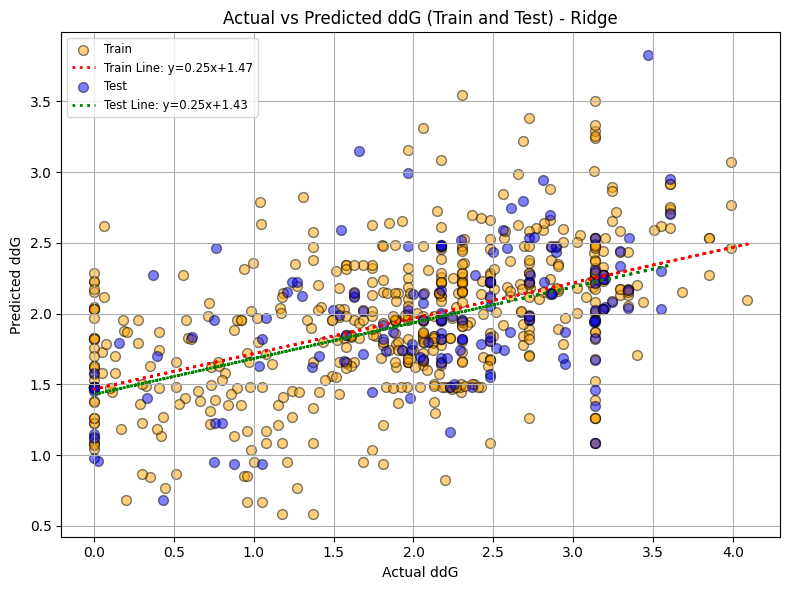


Model: SVR (Linear Kernel)
Best Parameters: {'model__C': 0.6808361216819946}
Train R²: 0.2257, MAE: 0.6645
Test R²: 0.2099, MAE: 0.6498


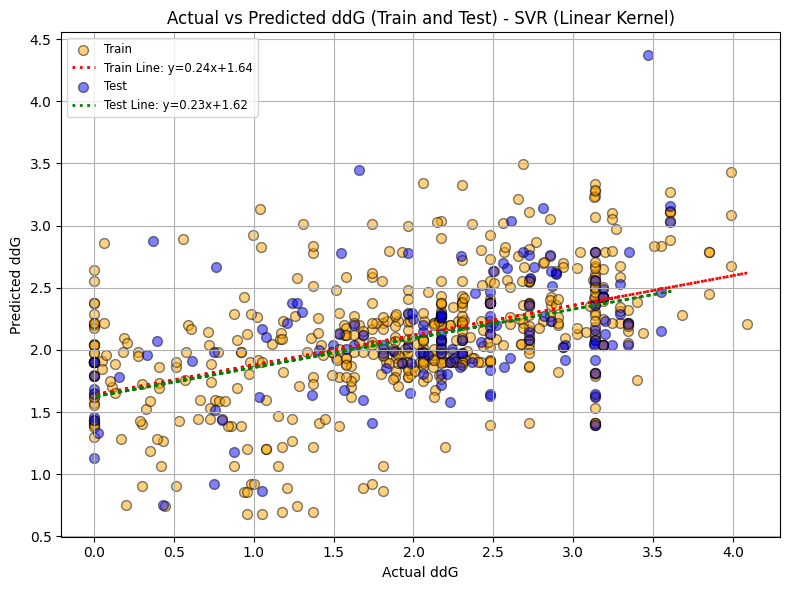


Model: SVR (Polynomial Kernel)
Best Parameters: {'model__C': 0.30584494295802445}
Train R²: 0.4431, MAE: 0.5125
Test R²: 0.4578, MAE: 0.5331


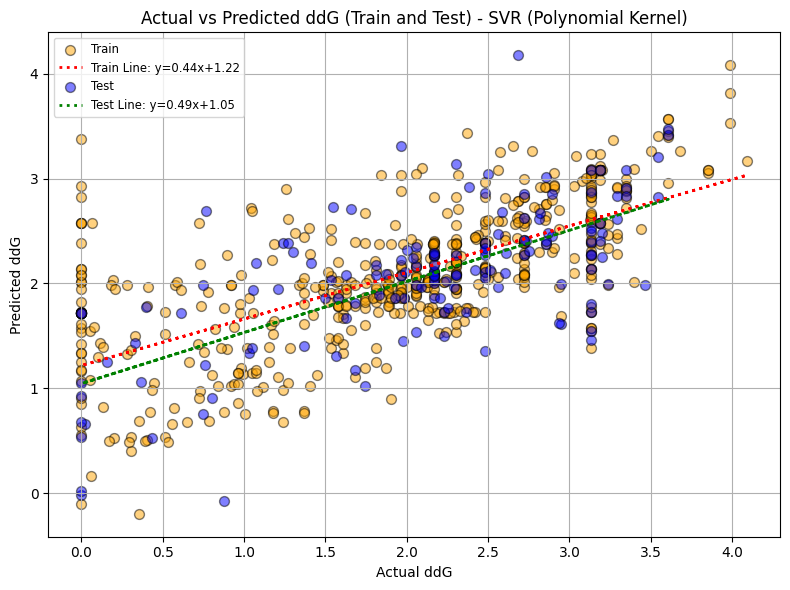


Model: Random Forest
Best Parameters: {'model__max_depth': 15, 'model__min_samples_split': 7, 'model__n_estimators': 60}
Train R²: 0.7142, MAE: 0.3618
Test R²: 0.5950, MAE: 0.4698


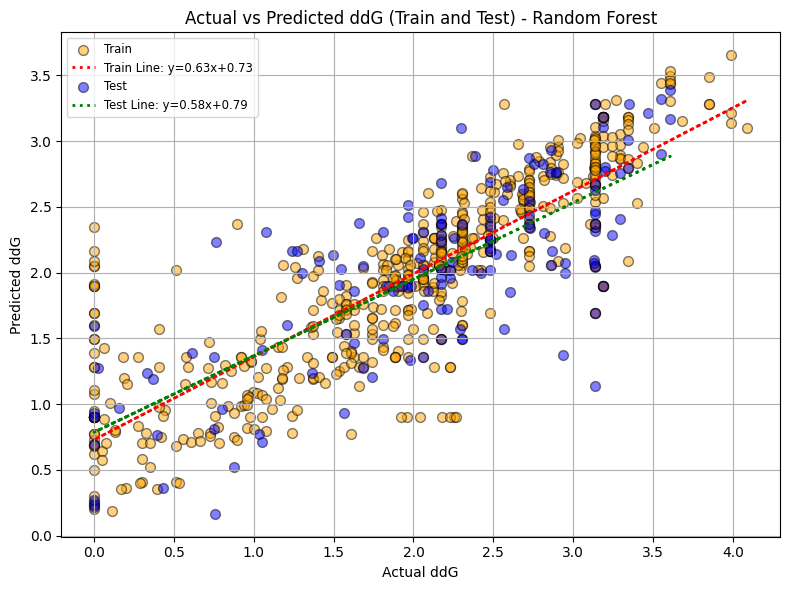


Model: Gradient Boosting
Best Parameters: {'model__learning_rate': 0.06502135295603015, 'model__max_depth': 6, 'model__min_samples_split': 6, 'model__n_estimators': 98}
Train R²: 0.7651, MAE: 0.2980
Test R²: 0.5898, MAE: 0.4581


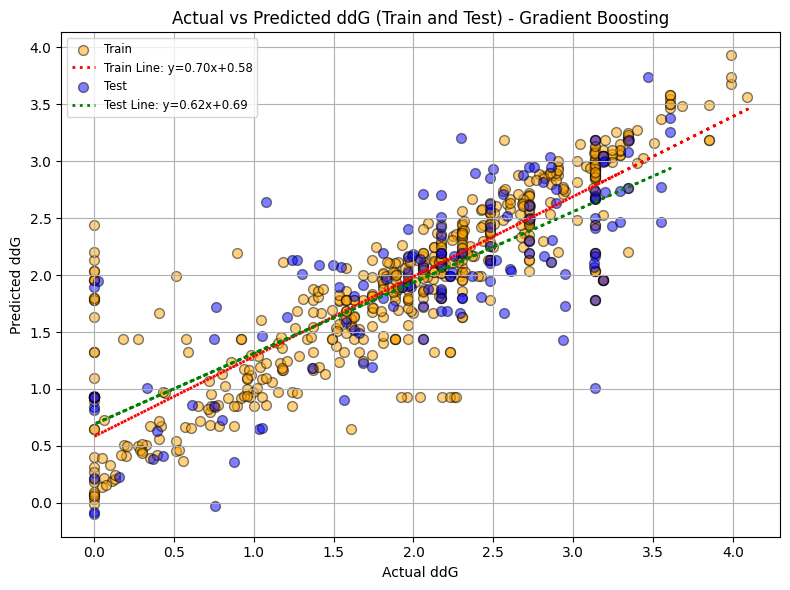

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
from sklearn.impute import SimpleImputer

# Assume vif_selector is either defined or we omit it in the pipeline
# from your_custom_module import vif_selector  # If VIFSelector is used

# Define a dictionary to store the best models
best_models = {}

# Sample models and their hyperparameters for RandomizedSearchCV
models = {
    'OLS': (LinearRegression(), {'model__fit_intercept': [True, False], 'model__n_jobs': [None, -1]}),
    'PLS': (PLSRegression(), {'model__n_components': randint(1, 5)}),
    'Lasso': (Lasso(), {'model__alpha': uniform(0.01, 1)}),
    'Ridge': (Ridge(), {'model__alpha': uniform(0.01, 10)}),
    'SVR (Linear Kernel)': (SVR(kernel='linear'), {'model__C': uniform(0.1, 10)}),
    'SVR (Polynomial Kernel)': (SVR(kernel='poly', degree=3), {'model__C': uniform(0.1, 10)}),
    'Random Forest': (RandomForestRegressor(random_state=42), {
        'model__n_estimators': randint(10, 200),
        'model__max_depth': randint(1, 20),
        'model__min_samples_split': randint(2, 10)
    }),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), {
        'model__n_estimators': randint(10, 200),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__max_depth': randint(1, 10),
        'model__min_samples_split': randint(2, 10)
    })
}

# Iterate through each model and perform RandomizedSearchCV
for model_name, (model, param_distributions) in models.items():
    # Create a pipeline with imputation, scaling, and the model
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
        ('scaler', MinMaxScaler()),  # Apply MinMaxScaler to features
        # ('vif', vif_selector),       # Optional: Handle multicollinearity if needed
        ('model', model)             # Apply the model
    ])
    
    # RandomizedSearchCV for hyperparameter tuning
    search = RandomizedSearchCV(pipe, param_distributions=param_distributions, n_iter=20, 
                                scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=42)

    # Fit the RandomizedSearchCV on the training data
    search.fit(X_train, y_train)

    # Best model from RandomizedSearchCV
    best_pipe = search.best_estimator_

    # Store the best model in the dictionary for later use
    best_models[model_name] = best_pipe

    # Predict on training data
    pred_X_train = best_pipe.predict(X_train)
    r2_train = r2_score(y_train, pred_X_train)
    mae_train = mean_absolute_error(y_train, pred_X_train)
    
    # Predict on test data
    pred_X_test = best_pipe.predict(X_test)
    r2_test = r2_score(y_test, pred_X_test)
    mae_test = mean_absolute_error(y_test, pred_X_test)
    
    # Output results
    print(f"\nModel: {model_name}")
    print(f"Best Parameters: {search.best_params_}")
    print(f"Train R²: {r2_train:.4f}, MAE: {mae_train:.4f}")
    print(f"Test R²: {r2_test:.4f}, MAE: {mae_test:.4f}")
    
    # Line of best fit for train and test metrics
    slope_train, intercept_train = np.polyfit(y_train, pred_X_train, 1)
    slope_test, intercept_test = np.polyfit(y_test, pred_X_test, 1)
    
    # Plotting both Train and Test data on the same plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, pred_X_train, color='orange', s=50, alpha=0.5, edgecolor='k', label='Train')
    plt.plot(y_train, slope_train * y_train + intercept_train, color='red', linestyle='dotted', linewidth=2, label=f'Train Line: y={slope_train:.2f}x+{intercept_train:.2f}')
    
    plt.scatter(y_test, pred_X_test, color='blue', s=50, alpha=0.5, edgecolor='k', label='Test')
    plt.plot(y_test, slope_test * y_test + intercept_test, color='green', linestyle='dotted', linewidth=2, label=f'Test Line: y={slope_test:.2f}x+{intercept_test:.2f}')
    
    plt.xlabel('Actual ddG')
    plt.ylabel('Predicted ddG')
    plt.title(f'Actual vs Predicted ddG (Train and Test) - {model_name}')
    plt.legend(loc='upper left', frameon=True, fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Access the best models later like:
# best_rf_model = best_models['Random Forest']


Plot QQ plots for to see the distribution of each feature

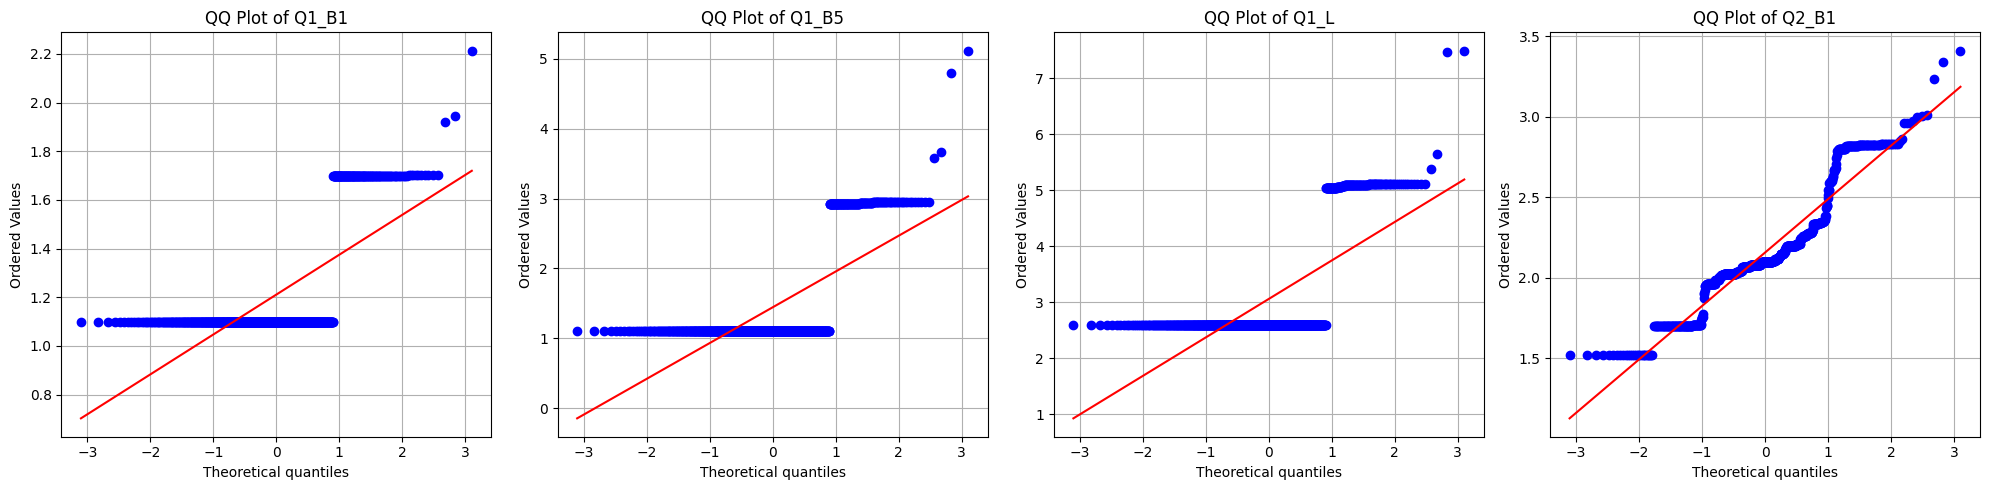

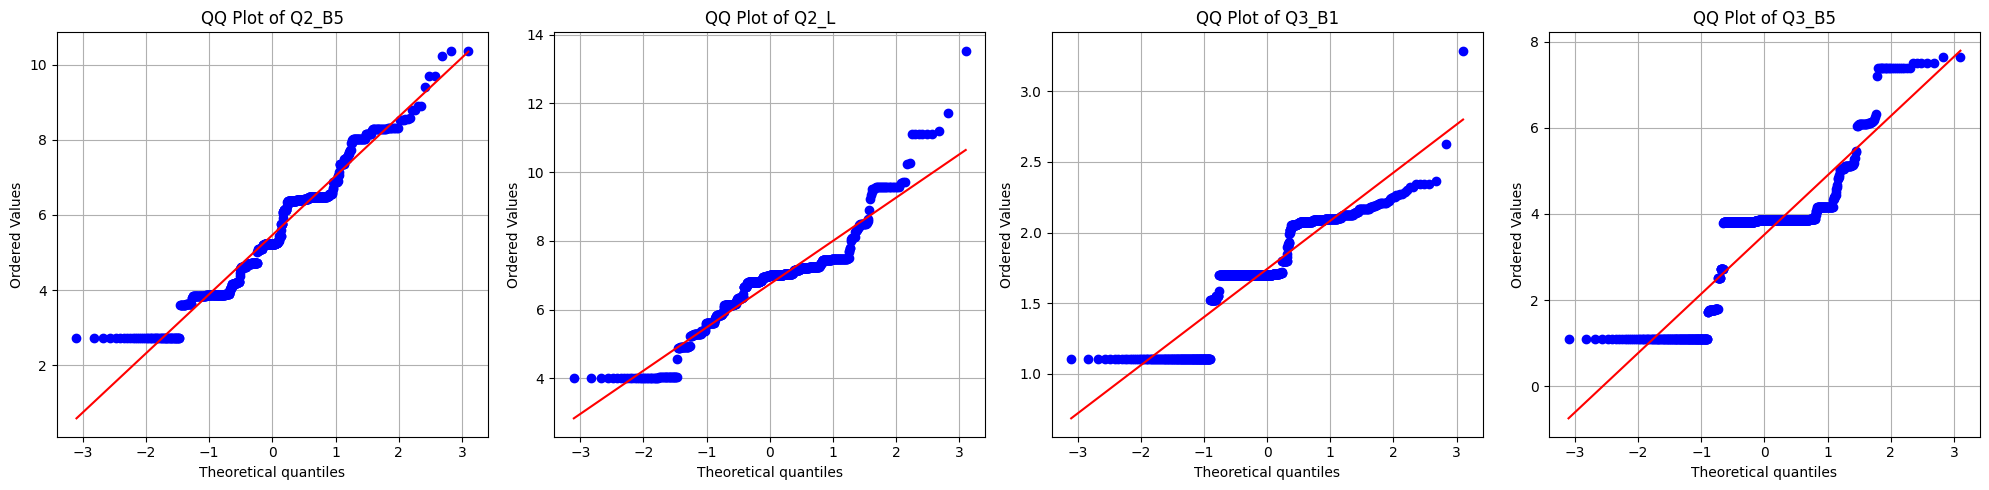

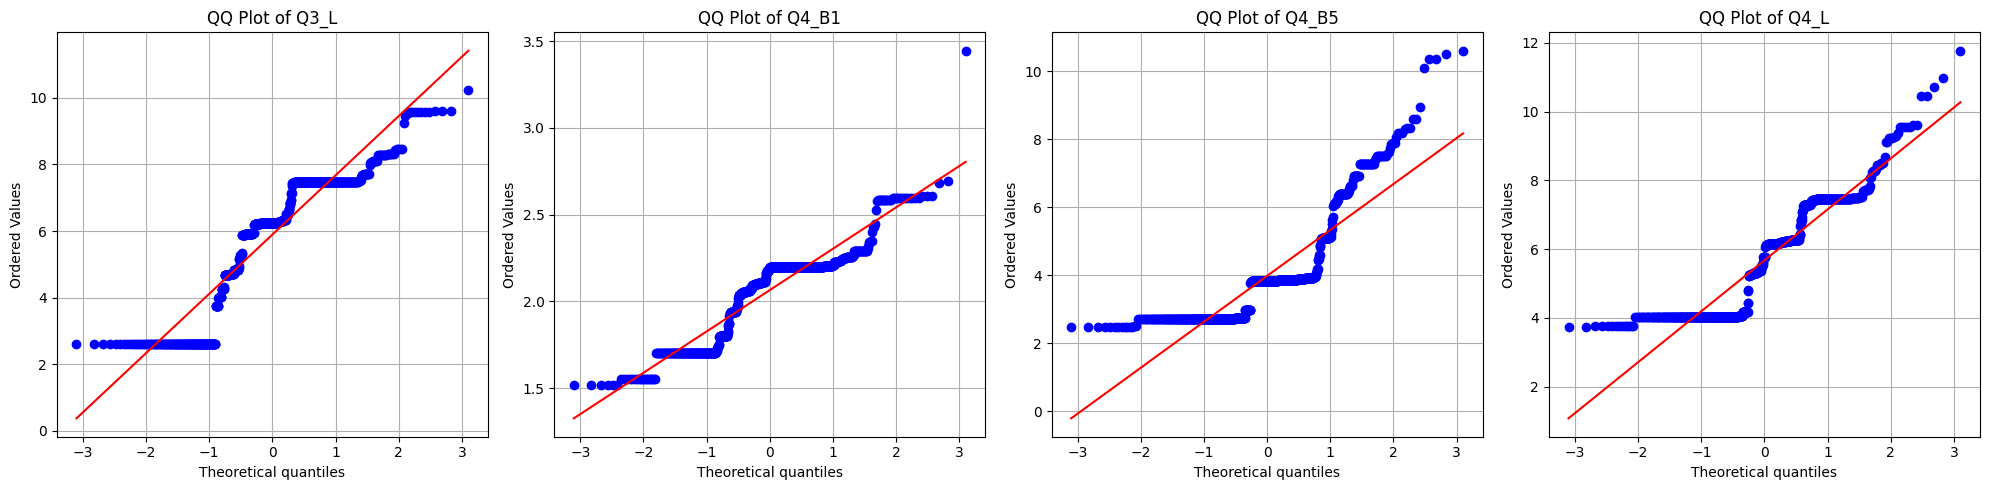

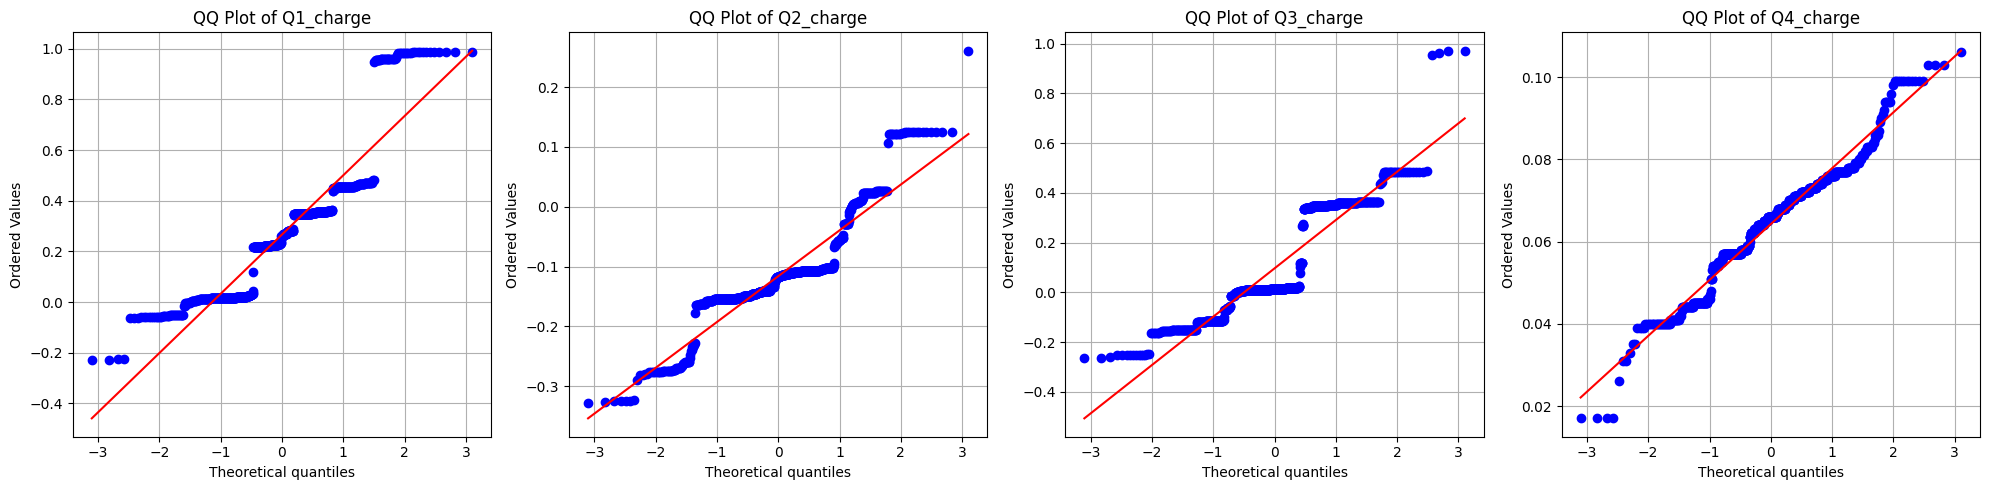

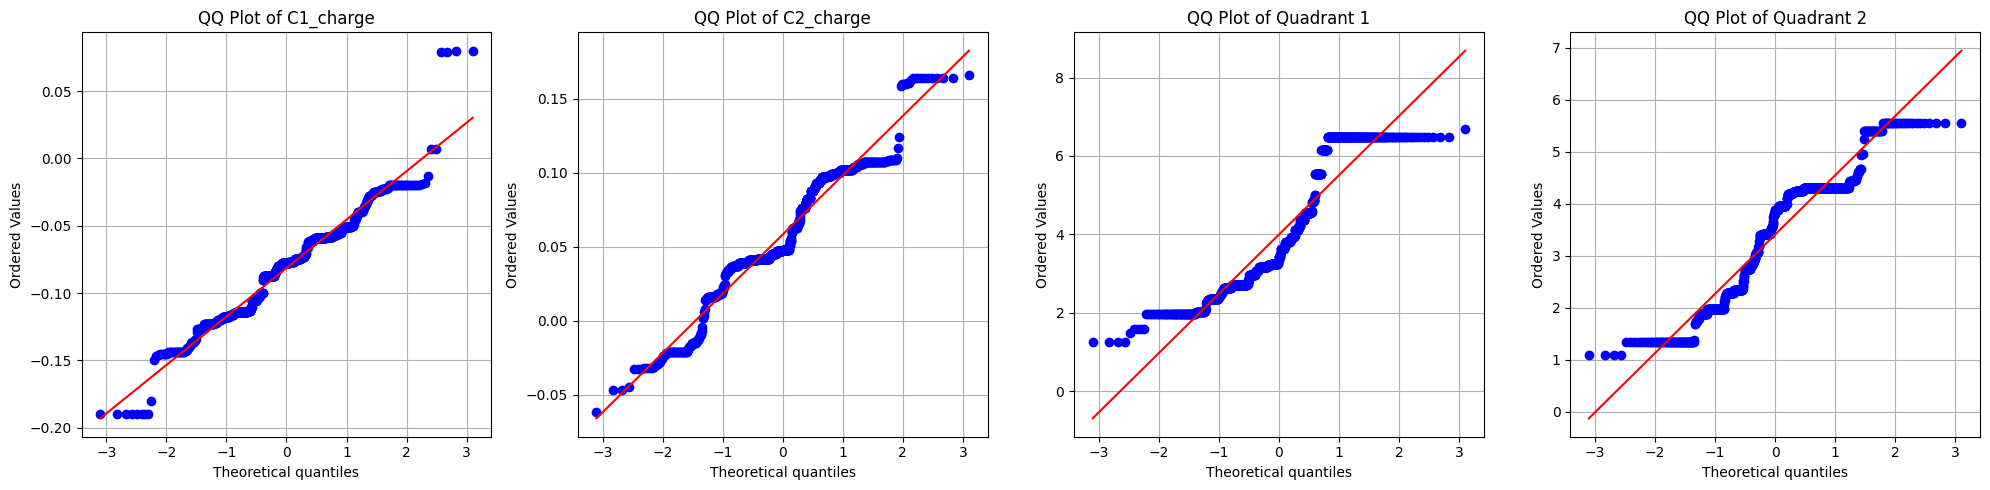

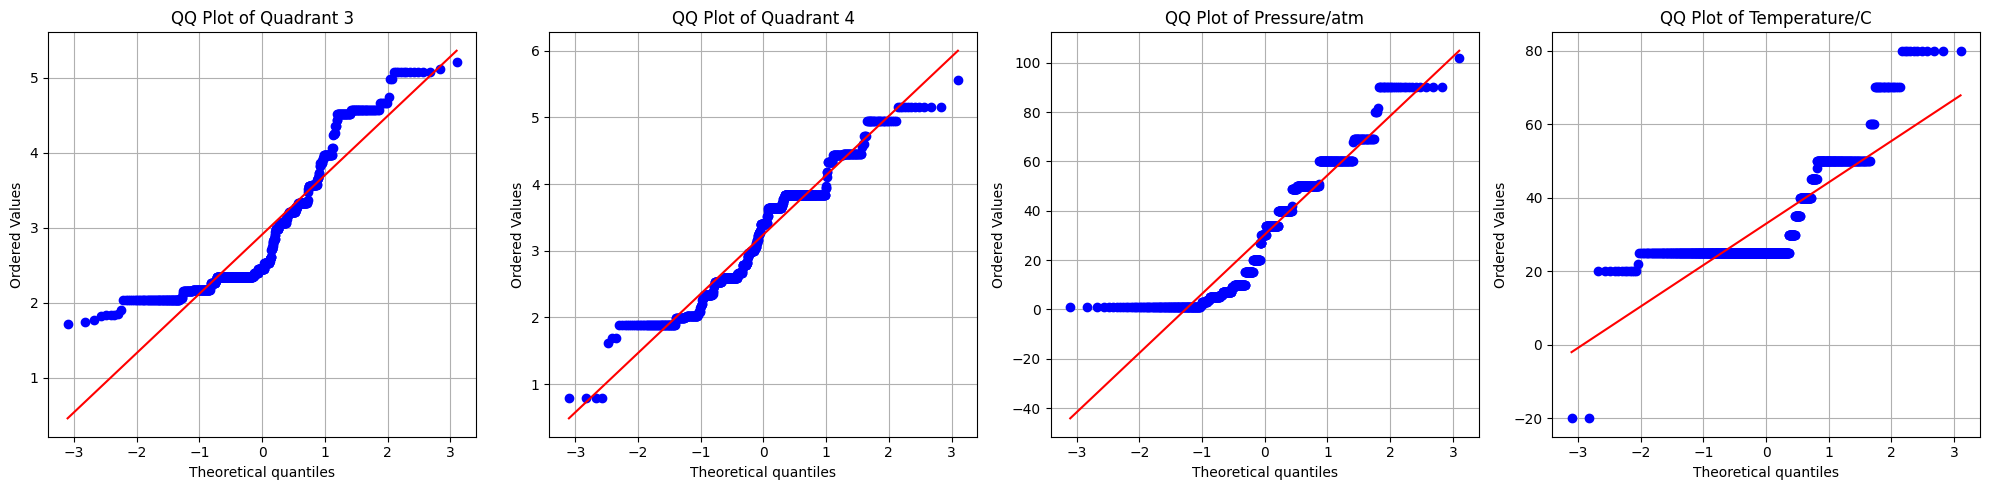

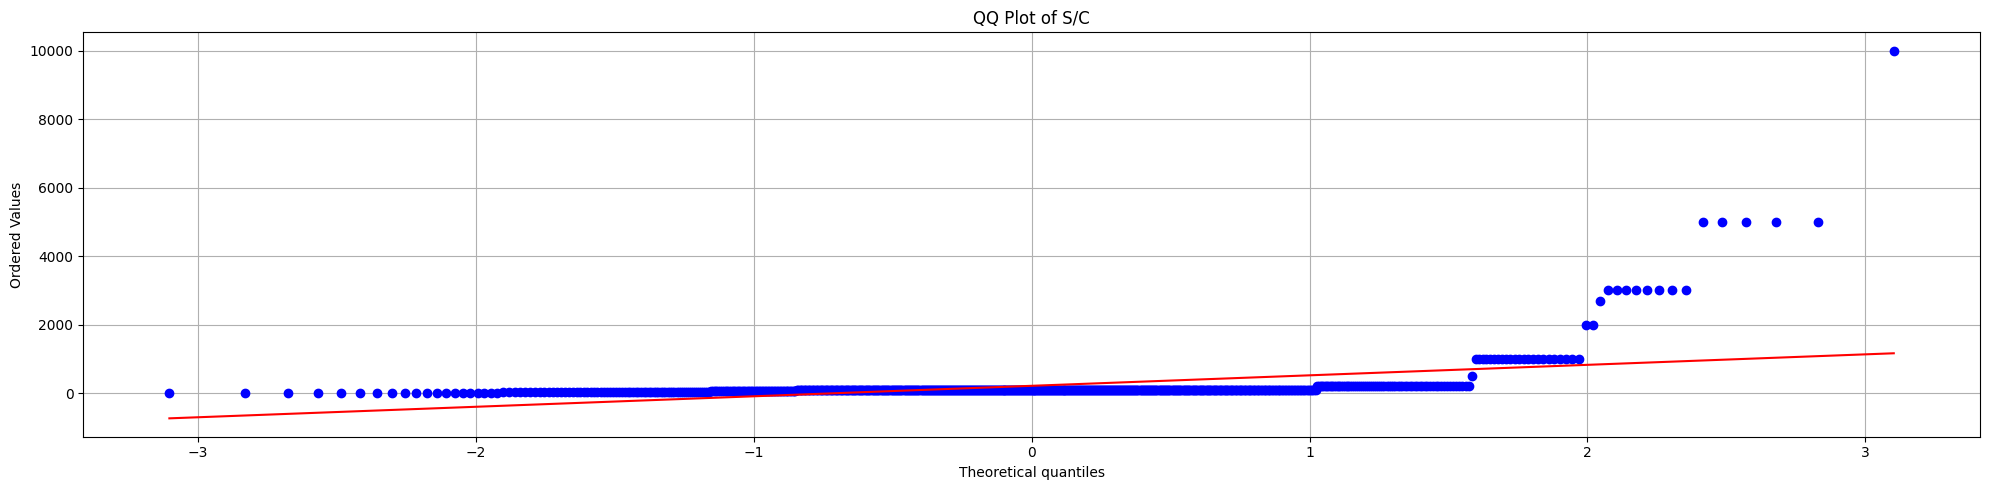

In [47]:
import scipy.stats as stats

X = tri_q2_df.drop(columns=['Rxn ID', 'Reactant ID', 'Catalyst ID', 'ddG', '_Alkene_Type', 'ee'])

num_columns = X.shape[1]  # Total number of columns (features)
cols_per_row = 4  # Number of plots per row

# Iterate over features and plot 4 QQ plots per row
for i in range(0, num_columns, cols_per_row):
    # Create subplots with 1 row and up to 4 columns
    fig, axes = plt.subplots(1, min(cols_per_row, num_columns - i), figsize=(20, 5))
    
    # Ensure axes is always a list, even if there's only one subplot
    if num_columns - i == 1:
        axes = [axes]
    
    # Iterate over each subplot
    for j, ax in enumerate(axes):
        if i + j < num_columns:
            column = X.columns[i + j]
            stats.probplot(X[column], dist="norm", plot=ax)
            ax.set_title(f"QQ Plot of {column}")
            ax.grid(True)
    
    plt.tight_layout()
    plt.show()


SCALE %ee and ddG based on temperature

In [22]:
import pandas as pd
import numpy as np

def eyring_equation(temperature, delta_H_dagger, delta_S_dagger):
    if temperature == 0 or pd.isna(temperature):
        return np.nan 
    
    k_B = 1.380649e-23  # Boltzmann constant in J/K
    h = 6.62607015e-34  # Planck's constant in J·s
    R = 8.314  # Gas constant in J/(mol·K)
    temperature_kelvin = temperature + 273.15
    rate_constant = (k_B * temperature_kelvin / h) * np.exp(-delta_H_dagger / (R * temperature_kelvin)) * np.exp(delta_S_dagger / R)
    return rate_constant

def calculate_delta_delta_G(temperature, ee, delta_H_dagger_major, delta_S_dagger_major, delta_H_dagger_minor, delta_S_dagger_minor):
    if temperature == 0 or pd.isna(temperature):
        return np.nan 
    
    k_major = eyring_equation(temperature, delta_H_dagger_major, delta_S_dagger_major)
    k_minor = eyring_equation(temperature, delta_H_dagger_minor, delta_S_dagger_minor)
    
    ee_factor = (1 + ee) / (1 - ee)
    delta_delta_G = 8.314 * (temperature + 273.15) * np.log(ee_factor)
    delta_delta_G /= 4184  
    
    return delta_delta_G

# Load the data
file_path = 'reordered_final_merged_cleaned_qqm_molecule_charges.xlsx'
df = pd.read_excel(file_path)

# Filter out rows where 'ee' is equal to 1
df = df[(df['Temperature/C'] > 0) & (df['ee'] != 1)].dropna(subset=['Temperature/C'])

# Constants for delta H and delta S values
constant_delta_H_dagger_major = 50000  # in J/mol
constant_delta_S_dagger_major = -100   # in J/(mol·K)
constant_delta_H_dagger_minor = 51000  # in J/mol
constant_delta_S_dagger_minor = -110   # in J/(mol·K)

# Calculate Scaled ΔΔG (kcal/mol)
df['Scaled ΔΔG (kcal/mol)'] = df.apply(
    lambda row: calculate_delta_delta_G(
        temperature=row['Temperature/C'],
        ee=row['ee'],  # Observed %ee
        delta_H_dagger_major=constant_delta_H_dagger_major,
        delta_S_dagger_major=constant_delta_S_dagger_major,
        delta_H_dagger_minor=constant_delta_H_dagger_minor,
        delta_S_dagger_minor=constant_delta_S_dagger_minor
    ), axis=1
)

# Display and save the output
print(df[['Temperature/C', 'ddG', 'ee', 'Scaled ΔΔG (kcal/mol)']].head())
df.to_excel('scaled_output_ddG_constant_ee_kcal.xlsx', index=False)


   Temperature/C       ddG    ee  Scaled ΔΔG (kcal/mol)
0           50.0  0.000000  0.00               0.000000
1           25.0  3.134376  0.99               3.136029
2           25.0  3.134376  0.99               3.136029
3           25.0  3.134376  0.99               3.136029
4           25.0  3.134376  0.99               3.136029


In [23]:
import pandas as pd

# Load the dataset
file_path = 'scaled_output_ddG_ee.xlsx' 
df = pd.read_excel(file_path)

# Step 1: Filter for the Tri_Q4 subset only
tri_q4_df = df[df['_Alkene_Type'] == 'Tri_Q4']

# Step 2: Refine temperature and S/C filtering based on the circled region in the QQ plot
# Focus on most common temperature values in the range: approx. -2 to 0.5 (you can adjust based on exact values)
temperature_lower_bound = tri_q4_df['Temperature/C'].quantile(0.05)  # Example range for -2 in QQ plot
temperature_upper_bound = tri_q4_df['Temperature/C'].quantile(0.50)  # Example range for 0.5 in QQ plot

# Refine S/C filtering based on your circled region, around S/C 75 to 125
sc_lower_bound = 75
sc_upper_bound = 125

# Apply refined filtering for both temperature and S/C
filtered_tri_q4_df = tri_q4_df[(tri_q4_df['Temperature/C'] >= temperature_lower_bound) & 
                               (tri_q4_df['Temperature/C'] <= temperature_upper_bound) &
                               (tri_q4_df['S/C'] >= sc_lower_bound) & 
                               (tri_q4_df['S/C'] <= sc_upper_bound)]

# Save the filtered dataset
filtered_file_path = 'tri_q4_scaled.xlsx'
filtered_tri_q4_df.to_excel(filtered_file_path, index=False)

# Display the number of entries filtered out
initial_count = tri_q4_df.shape[0]
filtered_count = filtered_tri_q4_df.shape[0]
filtered_out_count = initial_count - filtered_count

print(f"Initial Count (Tri_Q4): {initial_count}")
print(f"Filtered Count (Tri_Q4): {filtered_count}")
print(f"Filtered Out Count (Tri_Q4): {filtered_out_count}")

# Display a preview of the filtered dataframe
print(filtered_tri_q4_df.head())


Initial Count (Tri_Q4): 719
Filtered Count (Tri_Q4): 352
Filtered Out Count (Tri_Q4): 367
    Rxn ID Reactant ID Catalyst ID  Q1_B1     Q1_B5      Q1_L     Q2_B1  \
10    3900  react_1971      cat_13    1.7  2.954797  5.041945  2.063864   
17    2401  react_1971      cat_35    1.7  2.954797  5.041945  2.063864   
23    2403   react_464      cat_35    1.1  1.100000  2.594888  1.700000   
33    3811  react_2682      cat_87    1.1  1.100000  2.594888  2.822230   
34    3807   react_362      cat_87    1.1  1.100000  2.594888  2.820796   

       Q2_B5      Q2_L     Q3_B1  ...  Temperature/C    S/C       ddG    ee  \
10  3.834735  6.123291  1.100000  ...           25.0  100.0  0.191127  0.16   
17  3.834735  6.123291  1.100000  ...           25.0  100.0  3.197062  0.99   
23  5.080494  9.568174  2.096329  ...           25.0  100.0  2.933946  0.99   
33  6.485681  6.999551  2.121711  ...           25.0  100.0  0.749451  0.56   
34  6.488035  7.032913  2.164731  ...           25.0  100.0  0.9

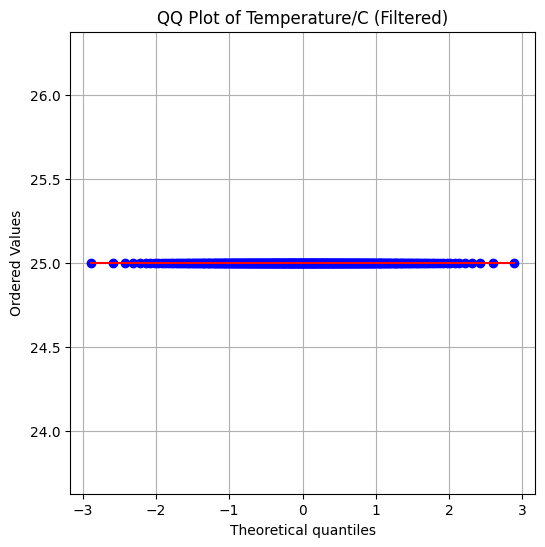

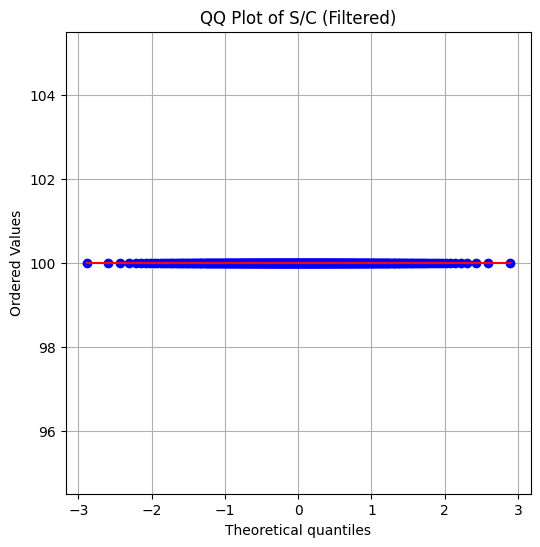

In [18]:
# Load the filtered dataset
filtered_file_path = 'tri_q4_scaled.xlsx'  # Update with your correct path
filtered_df = pd.read_excel(filtered_file_path)

# Generate QQ Plot for Temperature
plt.figure(figsize=(6, 6))
stats.probplot(filtered_df['Temperature/C'], dist="norm", plot=plt)
plt.title('QQ Plot of Temperature/C (Filtered)')
plt.grid(True)
plt.show()

# Generate QQ Plot for S/C
plt.figure(figsize=(6, 6))
stats.probplot(filtered_df['S/C'], dist="norm", plot=plt)
plt.title('QQ Plot of S/C (Filtered)')
plt.grid(True)
plt.show()


Cross-Validation: The block uses 5-fold cross-validation on the training set to assess the model's performance and consistency using MAE.
Final Evaluation: The model is trained on the entire training set and tested on the test set, with MAE and R² used to measure performance on unseen data.

In [20]:
# File paths for original and filtered datasets
original_file_path = 'scaled_output_ddG_ee.xlsx'
filtered_file_path = 'tri_q4_scaled.xlsx'

# Read the datasets
original_df = pd.read_excel(original_file_path)
filtered_df = pd.read_excel(filtered_file_path)

# Filter original dataframe for Tri_Q4 entries only
original_tri_q4_df = original_df[original_df['_Alkene_Type'] == 'Tri_Q4']

# Calculate the number of rows before and after filtering
original_count = original_tri_q4_df.shape[0]
filtered_count = filtered_df.shape[0]
filtered_out_count = original_count - filtered_count

# Display the counts
original_count, filtered_count, filtered_out_count


(719, 352, 367)

Number of rows in X_train: 281
Number of rows in y_train: 281
Number of rows in X_test: 71
Number of rows in y_test: 71

Model: OLS
Best Parameters: {'model__n_jobs': None, 'model__fit_intercept': True}
Train R²: 1.0000, MAE: 0.0000
Test R²: 1.0000, MAE: 0.0000


/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


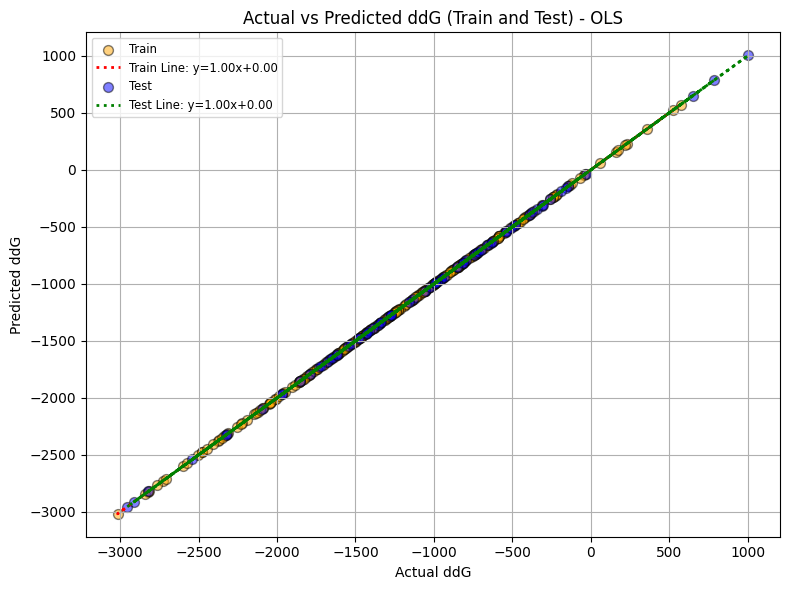


Model: PLS
Best Parameters: {'model__n_components': 4}
Train R²: 0.9987, MAE: 18.5711
Test R²: 0.9992, MAE: 17.2744


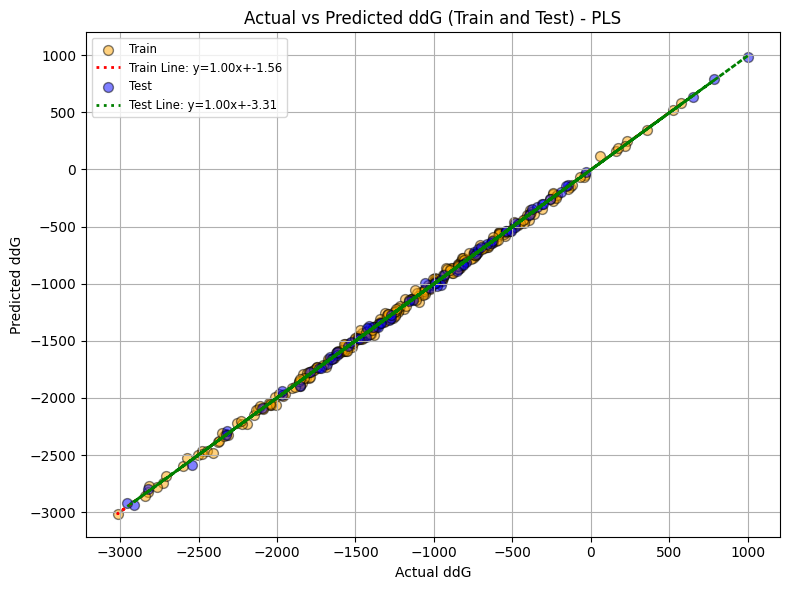


Model: Lasso
Best Parameters: {'model__alpha': 0.03058449429580245}
Train R²: 1.0000, MAE: 0.2978
Test R²: 1.0000, MAE: 0.3124


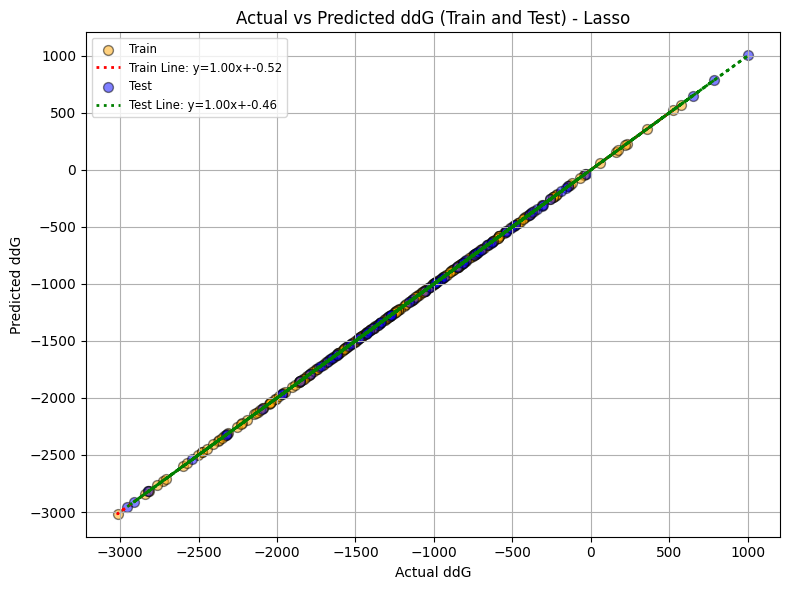


Model: Ridge
Best Parameters: {'model__alpha': 0.21584494295802448}
Train R²: 0.9993, MAE: 14.3971
Test R²: 0.9991, MAE: 18.3221


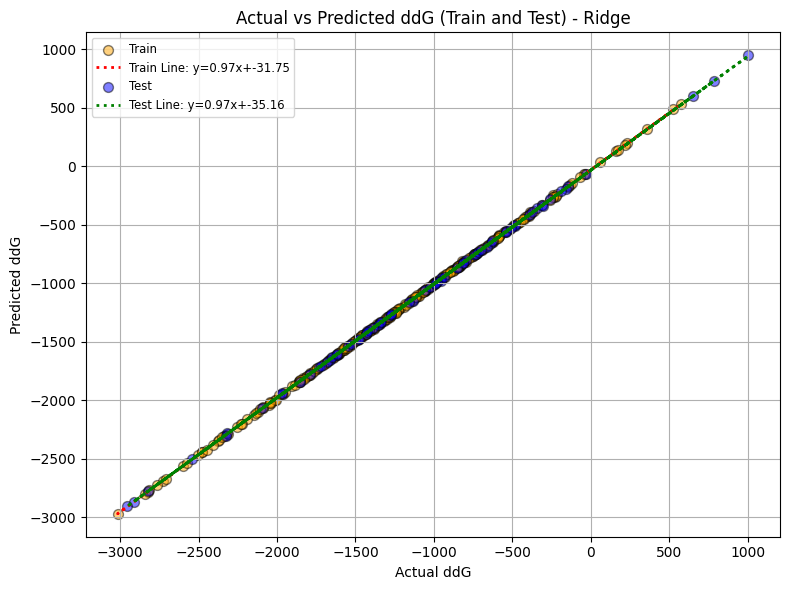


Model: SVR (Linear Kernel)
Best Parameters: {'model__C': 9.799098521619943}
Train R²: 0.1970, MAE: 470.0582
Test R²: 0.1679, MAE: 564.9929


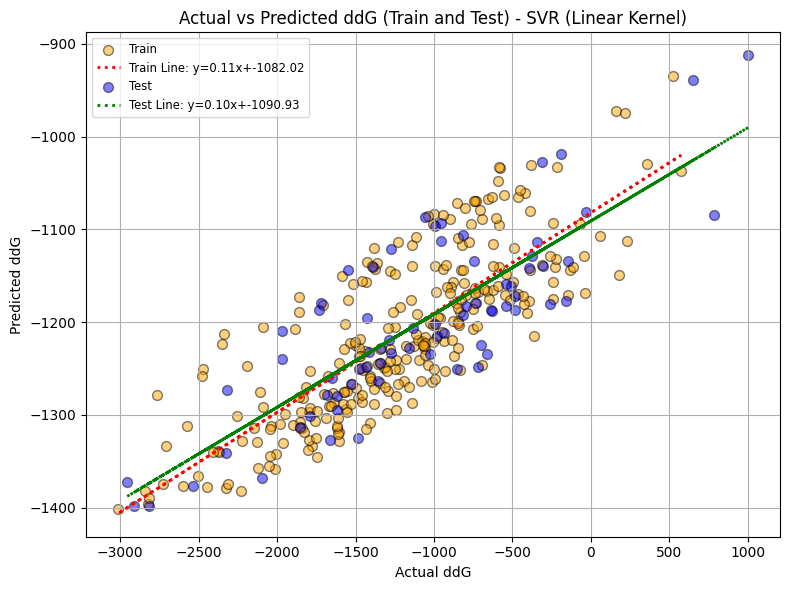


Model: SVR (Polynomial Kernel)
Best Parameters: {'model__C': 9.799098521619943}
Train R²: 0.8175, MAE: 211.3153
Test R²: 0.7863, MAE: 285.4363


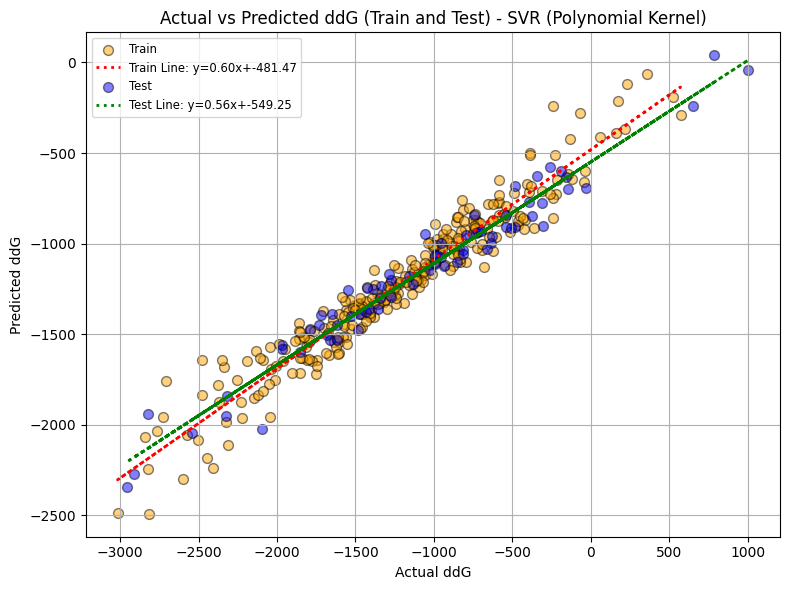


Model: Random Forest
Best Parameters: {'model__max_depth': 7, 'model__min_samples_split': 3, 'model__n_estimators': 84}
Train R²: 0.9906, MAE: 47.0385
Test R²: 0.9542, MAE: 112.2619


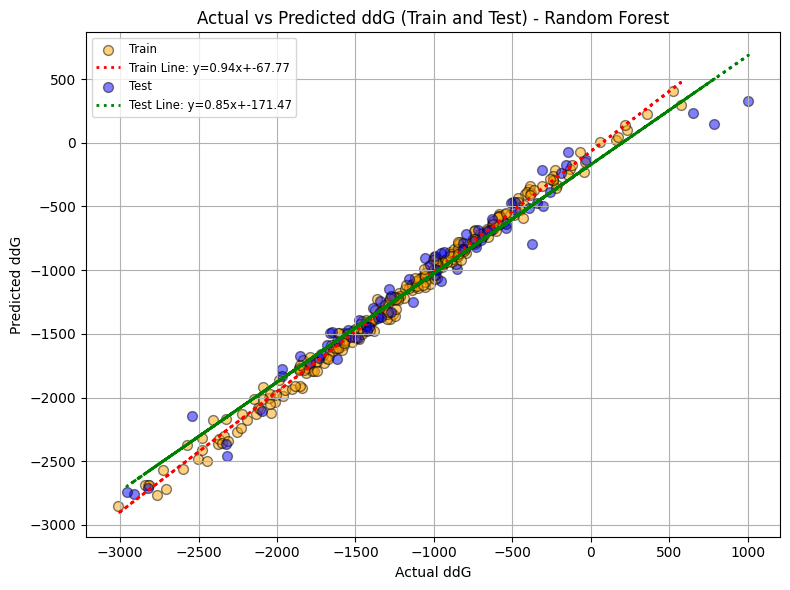


Model: Gradient Boosting
Best Parameters: {'model__learning_rate': 0.2087566853061946, 'model__max_depth': 2, 'model__min_samples_split': 7, 'model__n_estimators': 143}
Train R²: 0.9984, MAE: 20.5964
Test R²: 0.9782, MAE: 86.9686


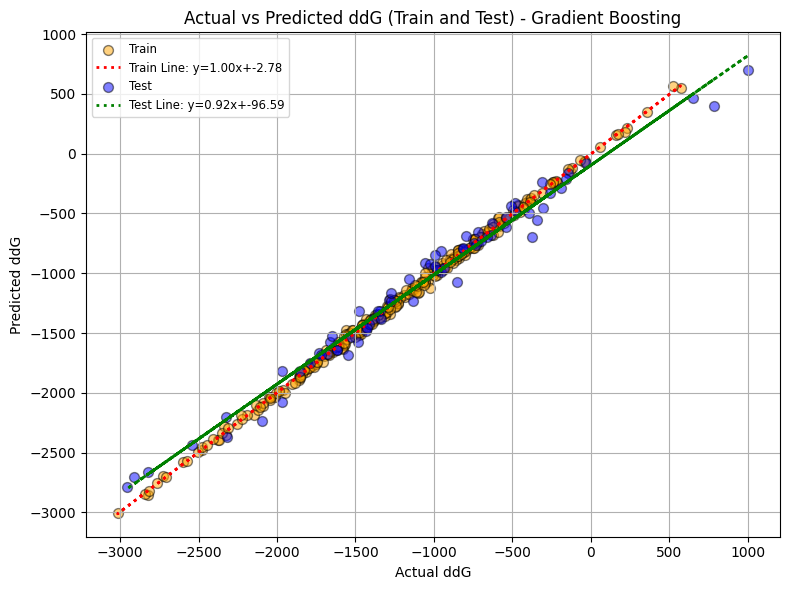

In [22]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
from sklearn.impute import SimpleImputer

# Load the filtered dataset
filtered_file_path = 'tri_q4_scaled.xlsx'  # Update with your correct path
df_filtered = pd.read_excel(filtered_file_path)

# Define feature columns and target variable (assuming 'Scaled ΔΔG (J/mol)' is the target)
X = df_filtered.drop(columns=['Scaled ΔΔG (J/mol)', 'Scaled ee', 'Rxn ID', 'Reactant ID', 'Catalyst ID', 'ddG', '_Alkene_Type', 'ee'])  # Features
y = df_filtered['Scaled ΔΔG (J/mol)']  # Target (ddG)

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop rows with NaNs in both feature and target sets
non_nan_indices_train = X_train.dropna().index.intersection(y_train.dropna().index)
X_train = X_train.loc[non_nan_indices_train].dropna()  # Ensure aligned rows and drop any remaining NaNs in features
y_train = y_train.loc[non_nan_indices_train].dropna()  # Align target variable with features

# Repeat similar steps for the test set
non_nan_indices_test = X_test.dropna().index.intersection(y_test.dropna().index)
X_test = X_test.loc[non_nan_indices_test].dropna()
y_test = y_test.loc[non_nan_indices_test].dropna()

# Print the number of rows to confirm alignment
print(f"Number of rows in X_train: {X_train.shape[0]}")
print(f"Number of rows in y_train: {y_train.shape[0]}")
print(f"Number of rows in X_test: {X_test.shape[0]}")
print(f"Number of rows in y_test: {y_test.shape[0]}")

# Define a dictionary to store the best models
best_models = {}

# Sample models and their hyperparameters for RandomizedSearchCV
models = {
    'OLS': (LinearRegression(), {'model__fit_intercept': [True, False], 'model__n_jobs': [None, -1]}),
    'PLS': (PLSRegression(), {'model__n_components': randint(1, 5)}),
    'Lasso': (Lasso(), {'model__alpha': uniform(0.01, 1)}),
    'Ridge': (Ridge(), {'model__alpha': uniform(0.01, 10)}),
    'SVR (Linear Kernel)': (SVR(kernel='linear'), {'model__C': uniform(0.1, 10)}),
    'SVR (Polynomial Kernel)': (SVR(kernel='poly', degree=3), {'model__C': uniform(0.1, 10)}),
    'Random Forest': (RandomForestRegressor(random_state=42), {
        'model__n_estimators': randint(10, 200),
        'model__max_depth': randint(1, 20),
        'model__min_samples_split': randint(2, 10)
    }),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), {
        'model__n_estimators': randint(10, 200),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__max_depth': randint(1, 10),
        'model__min_samples_split': randint(2, 10)
    })
}

# Iterate through each model and perform RandomizedSearchCV
for model_name, (model, param_distributions) in models.items():
    # Create a pipeline with imputation, scaling, and the model
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
        ('scaler', MinMaxScaler()),  # Apply MinMaxScaler to features
        ('model', model)             # Apply the model
    ])
    
    # RandomizedSearchCV for hyperparameter tuning
    search = RandomizedSearchCV(pipe, param_distributions=param_distributions, n_iter=20, 
                                scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=42)

    # Fit the RandomizedSearchCV on the training data
    search.fit(X_train, y_train)

    # Best model from RandomizedSearchCV
    best_pipe = search.best_estimator_

    # Store the best model in the dictionary for later use
    best_models[model_name] = best_pipe

    # Predict on training data
    pred_X_train = best_pipe.predict(X_train)
    r2_train = r2_score(y_train, pred_X_train)
    mae_train = mean_absolute_error(y_train, pred_X_train)
    
    # Predict on test data
    pred_X_test = best_pipe.predict(X_test)
    r2_test = r2_score(y_test, pred_X_test)
    mae_test = mean_absolute_error(y_test, pred_X_test)
    
    # Output results
    print(f"\nModel: {model_name}")
    print(f"Best Parameters: {search.best_params_}")
    print(f"Train R²: {r2_train:.4f}, MAE: {mae_train:.4f}")
    print(f"Test R²: {r2_test:.4f}, MAE: {mae_test:.4f}")
    
    # Line of best fit for train and test metrics
    slope_train, intercept_train = np.polyfit(y_train, pred_X_train, 1)
    slope_test, intercept_test = np.polyfit(y_test, pred_X_test, 1)
    
    # Plotting both Train and Test data on the same plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, pred_X_train, color='orange', s=50, alpha=0.5, edgecolor='k', label='Train')
    plt.plot(y_train, slope_train * y_train + intercept_train, color='red', linestyle='dotted', linewidth=2, label=f'Train Line: y={slope_train:.2f}x+{intercept_train:.2f}')
    
    plt.scatter(y_test, pred_X_test, color='blue', s=50, alpha=0.5, edgecolor='k', label='Test')
    plt.plot(y_test, slope_test * y_test + intercept_test, color='green', linestyle='dotted', linewidth=2, label=f'Test Line: y={slope_test:.2f}x+{intercept_test:.2f}')
    
    plt.xlabel('Actual ddG')
    plt.ylabel('Predicted ddG')
    plt.title(f'Actual vs Predicted ddG (Train and Test) - {model_name}')
    plt.legend(loc='upper left', frameon=True, fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
